In [135]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from itertools import groupby
import time
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.metrics import f1_score

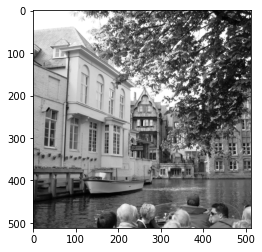

In [136]:
#Посмотрим изображение
im=imread('Data/Image00012.tif')
plt.imshow(im, cmap='Greys_r')

In [137]:
#некоторые значения, которые понадобятся на протяжении всего кода

#Ключ k
k=12

#количество пикселей в изображении
sh=im.shape[0]*im.shape[1]

name_dir='Data/'
files = os.listdir(path=name_dir)
K=len(files)
K2=int(K/2)

In [138]:
#псевдослучайные числа с равной вероятностью принимающее положительные и отрицательные значения 
def random_numbers(n):
    return [random.choice([-1,1]) for i in range(0,n)]

#генерация расположения пикселей, в которые будет вписываться сообщение
def random_loc(n,sh):
    return [random.randint(0,sh-1) for i in range(0,n)]

#получение первого бита
def bin2(s):
    return int('{:08b}'.format(s)[7])

In [139]:
#добавление шума к изображению по методу +-1
def add_noise(k,image,n,location,rand_n,b):#k - ключ, n - кол. пикселей, которое будет изменено, b - шум
    #преобразуем в одномерный массив
    image_one = image.flatten()
    
    f={0:1,255:254}

    for l in range(len(location)):
        loc=location[l]
        img=image_one[loc]
    
        if(img in f):
            image_one[loc]=f[img]
        elif(bin2(img)!=b[l]):
            image_one[loc]+=rand_n[l]

    return np.reshape(image_one, image.shape) 

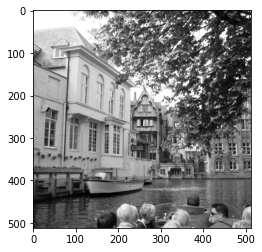

In [140]:
#Проверим работу add_noise
n=50000
b=np.random.randint(2, size=n)
random.seed(k)
rand_n=random_numbers(n)
location=random_loc(n,sh)

im_new=add_noise(k,im,n,location,rand_n,b)
plt.imshow(im_new, cmap='Greys_r')

#plt.imshow(new_image, cmap='Greys_r')

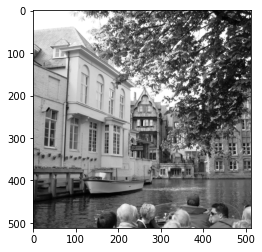

In [141]:
plt.imshow(im, cmap='Greys_r')

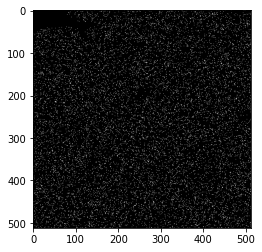

In [142]:
plt.imshow(im-im_new, cmap='Greys_r')


In [107]:
#метод развертки двумерной плоскости (серпантинная)
def scan(image):
    n1,n2=image.shape
    image_scan=np.zeros(n1*n2,dtype=int)
    
    for i in range(0,n1):
        first=i*n2
        second=(i+1)*n2
        
        if(i%2==0):
            image_scan[first:second]=image[i]
        else:
            image_scan[first:second]=image[i][::-1]
    
    return image_scan

In [108]:
#рассчёт длины серий различной длины (нолей)
def c_of_series(image_scan_b1):
    res = ([len(list(g)) for i,g in groupby(image_scan_b1) if i==0])
    dict_s=np.zeros(20,dtype=int)
    
    for i in range(20):
        dict_s[i]=res.count(i+1)
        
    return dict_s

In [109]:
#f=dict.fromkeys(range(1,21))

В качестве первого варианта набора признаков выбраны длины серий.
Максимальная длина - 20  
(Наборы признаков хранятся в папке D)  
В качестве второго - частоты переходов  
(Наборы признаков хранятся в папке D2)

In [110]:
# метод для первых K/2 изображений, добаляем шут и получаем серии
def add_noise_to_half_of_images(name_dir,k,n,sh):
    
    #Получаем названия всех изображений 
    files = os.listdir(path=name_dir)
    K2=int(len(files)/2)
    name_dir_sp = [name_dir] * K2
    name_file=list(map(os.path.join,name_dir_sp,files[0:K2]))
    
    sp_s=np.zeros((K2,20),dtype=int)
    n=int(n*sh/100)
    
    #генерируем шум
    b=np.random.randint(2, size=n)
    
    #генерируем последовательность псевдослучафных чисел
    random.seed(k)
    rand_n=random_numbers(n)
    
    #генерируем местоположение пикселей
    location=random_loc(n,sh)
    
    for i in range(K2):
        
        #считываем изображение
        img=imread(name_file[i])
        
        #добавляем шум
        noise_img=add_noise(k,img,n,location,rand_n,b)
        
        #серпантинная развертка
        image_scan=scan(noise_img)
        
        #получение 1 плоскости
        image_scan_b1=list(map(bin2,image_scan))
        
        #рассчёт серий
        sp_s[i][:]=c_of_series(image_scan_b1)
        
    return sp_s
    

In [111]:
# метод для вторых K/2 изображений, получаем серии
def ser2(name_dir):
    files = os.listdir(path=name_dir)
    K=len(files)
    K2=int(K/2)
    sp_s=np.zeros((K2,20),dtype=int)
    
    for i in range(0,K2):
        #считываем изображение
        img = imread(name_dir+files[i+K2])
        
        #серпантинная развертка
        image_scan=scan(img)
        
        #получение 1 плоскости
        image_scan_b1=list(map(bin2,image_scan))
        
        #рассчёт серий
        sp_s[i][:]=c_of_series(image_scan_b1)
           
    return sp_s

In [112]:
#Метод для создания датасетов, с разной заполненостью
def create_dataset(step,name_dir,k,sh):
    sp_2=ser2(name_dir)
    for i in range(20,100+step,step):
        sp=add_noise_to_half_of_images(name_dir,k,i,sh)
        res=np.concatenate([sp, sp_2])
        df=pd.DataFrame(data=res,columns=pd.RangeIndex(range(1, 20+1)))
        df.to_csv('D/Dataset_'+str(i)+'.csv',index=False)  

In [113]:
#create_dataset(10,name_dir,k,sh)

Второй способ формирования признаков - частоты

In [114]:
# метод для первых K/2 изображений, добаляем шут и считаем частоты
def add_noise_to_half_of_images_2(name_dir,k,n,sh):
    files = os.listdir(path=name_dir)
    K2=int(len(files)/2)
    
    sp_s=np.zeros((K2,4),dtype=int)
    n=int(n*sh/100)
    
    b=np.random.randint(2, size=n)
    
    #генерируем последовательность псевдослучафных чисел
    random.seed(k)
    rand_n=random_numbers(n)
    
    #генерируем местоположение пикселей
    location=random_loc(n,sh)
    
    
    for i in range(K2):
        
        #считываем изображение
        img=imread(name_dir+files[i])
        
        #добавляем шум
        noise_img=add_noise(k,img,n,location,rand_n,b)
        
        #серпантинная развертка
        image_scan=scan(noise_img)
        
        #получение 1 плоскости
        image_scan_b1=list(map(bin2,image_scan))
        
        #расчёт частот
        sp_s[i][:]=p(image_scan_b1)
        
    return sp_s
    

In [115]:
# метод для вторых K/2 изображений, считаем частоты
def ser2_2(name_dir):
    files = os.listdir(path=name_dir)
    K=len(files)
    K2=int(K/2)
    sp_s=np.zeros((K2,4),dtype=int)
    
    for i in range(0,K2):
        #считываем изображение
        img = imread(name_dir+files[i+K2])
        
        #серпантинная развертка
        image_scan=scan(img)
        
        #получение 1 плоскости
        image_scan_b1=list(map(bin2,image_scan))
        
        #расчёт частот
        sp_s[i][:]=p(image_scan_b1)
        
    return sp_s

In [116]:
#расчёт частот
def p(bet):
    N=len(bet)
    g00,g01,g10,g11=0,0,0,0
    
    for i in range(N-2):
        if(bet[i]==0 and bet[i+1]==0):
            g00+=1
        elif(bet[i]==0 and bet[i+1]==1):
            g01+=1
        elif(bet[i]==1 and bet[i+1]==0):
            g10+=1
        elif(bet[i]==1 and bet[i+1]==1):
            g11+=1
    return g00,g01,g10,g11

In [117]:
#Метод для создания датасетов, с разной заполненостью для второго случая
def create_dataset_2(step,name_dir,k,sh):
    sp_2=ser2_2(name_dir)
    for i in range(20,100+step,step):
        sp=add_noise_to_half_of_images_2(name_dir,k,i,sh)
        res=np.concatenate([sp, sp_2])
        df=pd.DataFrame(data=res,columns=pd.RangeIndex(range(1, 4+1)))
        df.to_csv('D2/Dataset_'+str(i)+'.csv',index=False) 

In [118]:
#create_dataset_2(10,name_dir,k,sh)

##### Наборы признаков были сформированы, далее пойдет обучение

In [119]:
#метод разделения данных на тестовую и обучающую выборки
def test_and_train(K,df,y):
    n=int(K/2*0.7)
    a=df.head(n)
    b=df.tail(n)
    train_X=pd.concat([a,b],ignore_index=True)
    
    test_X=df.iloc[:-n].iloc[n:]
    test_X.reset_index(drop= True , inplace= True )
    
    train_y=y[:n]+y[-n:]
    
    test_y=y[n:-n]
    return train_X,test_X,train_y,test_y

In [120]:
#Рассмотрим насколько хорошо работают различные классификаторы
#на наборе сo 100-ной заполненостью
df=pd.read_csv('D/Dataset_'+str(100)+'_num_'+str(20)+'.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,32684,16389,8002,4056,2061,1027,517,256,155,68,36,20,8,6,1,2,0,1,0,0
1,32204,16088,8248,4180,2036,1104,574,307,157,81,36,14,12,4,5,2,1,1,0,0
2,32396,16256,8199,4124,2032,1066,545,311,146,75,36,15,14,10,2,1,3,1,1,1
3,32533,16493,8207,4135,2011,1035,520,272,131,73,43,10,9,8,2,0,1,1,0,0
4,32866,16342,8199,4123,2042,1001,468,256,134,66,33,15,18,3,1,7,1,0,0,0


In [121]:
y=list(np.concatenate([np.ones(K2,dtype=int), np.zeros(K2,dtype=int)]))# это верная классификация
train_X,test_X,train_y,test_y=test_and_train(K,df,y)

In [122]:
models = {}

models['LogisticRegression'] = LogisticRegression()

models['SVC_linear'] = svm.SVC(kernel = 'linear')

models['SVC_rbf'] = svm.SVC(kernel = 'rbf')

models['LinearDiscriminantAnalysis'] = LDA()

models['DecisionTreeClassifier'] = DecisionTreeClassifier()

models['RandomForestClassifier'] = RandomForestClassifier()

models['AdaBoostClassifier'] = AdaBoostClassifier()

models['CatBoostClassifier'] = cb.CatBoostClassifier()

models['KNeighborsClassifier'] = KNeighborsClassifier()

In [123]:
accuracy, f1,f1_mean = {}, {},{}
for key in models.keys():
    
    models[key].fit(train_X, train_y)
    predictions = models[key].predict(test_X)
    accuracy[key] = accuracy_score(predictions, test_y)

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.008847
0:	learn: 0.6850772	total: 2.54ms	remaining: 2.54s
1:	learn: 0.6759566	total: 4.96ms	remaining: 2.48s
2:	learn: 0.6679224	total: 7.36ms	remaining: 2.45s
3:	learn: 0.6616060	total: 9.64ms	remaining: 2.4s
4:	learn: 0.6549877	total: 12ms	remaining: 2.39s
5:	learn: 0.6493857	total: 14.4ms	remaining: 2.39s
6:	learn: 0.6410583	total: 16.9ms	remaining: 2.4s
7:	learn: 0.6327230	total: 19.1ms	remaining: 2.37s
8:	learn: 0.6252791	total: 21.4ms	remaining: 2.35s
9:	learn: 0.6186082	total: 23.6ms	remaining: 2.34s
10:	learn: 0.6108761	total: 26.3ms	remaining: 2.36s
11:	learn: 0.6038117	total: 29.2ms	remaining: 2.4s
12:	learn: 0.5990931	total: 31.6ms	remaining: 2.4s
13:	learn: 0.5916678	total: 34.1ms	remaining: 2.4s
14:	learn: 0.5851766	total: 36.4ms	remaining: 2.39s
15:	learn: 0.5795538	total: 38.7ms	remaining: 2.38s
16:	learn: 0.5727336	total: 40.9ms	remaining: 2.37s
17:	learn: 0.5680785	total: 43.4ms	remaining: 2.37s
18:	learn: 0.5626051	total: 45.9ms	remaining: 2.37s

224:	learn: 0.2275313	total: 519ms	remaining: 1.79s
225:	learn: 0.2271663	total: 522ms	remaining: 1.79s
226:	learn: 0.2268821	total: 524ms	remaining: 1.78s
227:	learn: 0.2263509	total: 526ms	remaining: 1.78s
228:	learn: 0.2259538	total: 529ms	remaining: 1.78s
229:	learn: 0.2250432	total: 532ms	remaining: 1.78s
230:	learn: 0.2244839	total: 534ms	remaining: 1.78s
231:	learn: 0.2239520	total: 537ms	remaining: 1.78s
232:	learn: 0.2234639	total: 539ms	remaining: 1.77s
233:	learn: 0.2230994	total: 541ms	remaining: 1.77s
234:	learn: 0.2226828	total: 543ms	remaining: 1.77s
235:	learn: 0.2222573	total: 546ms	remaining: 1.77s
236:	learn: 0.2218626	total: 549ms	remaining: 1.77s
237:	learn: 0.2215280	total: 551ms	remaining: 1.76s
238:	learn: 0.2210680	total: 553ms	remaining: 1.76s
239:	learn: 0.2204124	total: 555ms	remaining: 1.76s
240:	learn: 0.2202137	total: 557ms	remaining: 1.75s
241:	learn: 0.2197255	total: 560ms	remaining: 1.75s
242:	learn: 0.2192242	total: 562ms	remaining: 1.75s
243:	learn: 

447:	learn: 0.1634901	total: 1.05s	remaining: 1.29s
448:	learn: 0.1633678	total: 1.05s	remaining: 1.29s
449:	learn: 0.1632121	total: 1.05s	remaining: 1.29s
450:	learn: 0.1629821	total: 1.05s	remaining: 1.28s
451:	learn: 0.1629033	total: 1.06s	remaining: 1.28s
452:	learn: 0.1628850	total: 1.06s	remaining: 1.28s
453:	learn: 0.1627186	total: 1.06s	remaining: 1.28s
454:	learn: 0.1624597	total: 1.07s	remaining: 1.28s
455:	learn: 0.1622403	total: 1.07s	remaining: 1.27s
456:	learn: 0.1619425	total: 1.07s	remaining: 1.27s
457:	learn: 0.1616310	total: 1.07s	remaining: 1.27s
458:	learn: 0.1614244	total: 1.07s	remaining: 1.27s
459:	learn: 0.1610382	total: 1.08s	remaining: 1.27s
460:	learn: 0.1607897	total: 1.08s	remaining: 1.26s
461:	learn: 0.1604943	total: 1.08s	remaining: 1.26s
462:	learn: 0.1604655	total: 1.08s	remaining: 1.26s
463:	learn: 0.1601839	total: 1.09s	remaining: 1.26s
464:	learn: 0.1599698	total: 1.09s	remaining: 1.25s
465:	learn: 0.1598743	total: 1.09s	remaining: 1.25s
466:	learn: 

681:	learn: 0.1205434	total: 1.58s	remaining: 735ms
682:	learn: 0.1205319	total: 1.58s	remaining: 733ms
683:	learn: 0.1205025	total: 1.58s	remaining: 731ms
684:	learn: 0.1203167	total: 1.58s	remaining: 729ms
685:	learn: 0.1201048	total: 1.59s	remaining: 726ms
686:	learn: 0.1197630	total: 1.59s	remaining: 724ms
687:	learn: 0.1194968	total: 1.59s	remaining: 722ms
688:	learn: 0.1193047	total: 1.59s	remaining: 720ms
689:	learn: 0.1191173	total: 1.6s	remaining: 718ms
690:	learn: 0.1188750	total: 1.6s	remaining: 715ms
691:	learn: 0.1188542	total: 1.6s	remaining: 713ms
692:	learn: 0.1185184	total: 1.6s	remaining: 710ms
693:	learn: 0.1181299	total: 1.6s	remaining: 708ms
694:	learn: 0.1180133	total: 1.61s	remaining: 705ms
695:	learn: 0.1177125	total: 1.61s	remaining: 704ms
696:	learn: 0.1176950	total: 1.61s	remaining: 701ms
697:	learn: 0.1173130	total: 1.61s	remaining: 699ms
698:	learn: 0.1170052	total: 1.62s	remaining: 697ms
699:	learn: 0.1168433	total: 1.62s	remaining: 694ms
700:	learn: 0.116

899:	learn: 0.0896165	total: 2.11s	remaining: 234ms
900:	learn: 0.0894411	total: 2.11s	remaining: 232ms
901:	learn: 0.0893120	total: 2.11s	remaining: 230ms
902:	learn: 0.0893073	total: 2.12s	remaining: 227ms
903:	learn: 0.0893027	total: 2.12s	remaining: 225ms
904:	learn: 0.0892267	total: 2.12s	remaining: 223ms
905:	learn: 0.0890786	total: 2.12s	remaining: 220ms
906:	learn: 0.0889062	total: 2.13s	remaining: 218ms
907:	learn: 0.0887559	total: 2.13s	remaining: 216ms
908:	learn: 0.0886336	total: 2.13s	remaining: 214ms
909:	learn: 0.0885462	total: 2.14s	remaining: 211ms
910:	learn: 0.0884076	total: 2.14s	remaining: 209ms
911:	learn: 0.0883843	total: 2.14s	remaining: 207ms
912:	learn: 0.0882843	total: 2.14s	remaining: 204ms
913:	learn: 0.0880830	total: 2.15s	remaining: 202ms
914:	learn: 0.0878123	total: 2.15s	remaining: 200ms
915:	learn: 0.0876081	total: 2.15s	remaining: 197ms
916:	learn: 0.0874339	total: 2.15s	remaining: 195ms
917:	learn: 0.0874289	total: 2.16s	remaining: 193ms
918:	learn: 

In [124]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy'])
df_model['Accuracy'] = accuracy.values()
sorted_df = df_model.sort_values(by='Accuracy')
sorted_df
#sorted_df.tail()

,Accuracy
SVC_rbf,0.683333
DecisionTreeClassifier,0.820000
LinearDiscriminantAnalysis,0.846667
RandomForestClassifier,0.863333
KNeighborsClassifier,0.863333
AdaBoostClassifier,0.870000
LogisticRegression,0.880000
CatBoostClassifier,0.886667
SVC_linear,0.910000


In [125]:
#Попробуем повысить точность классификатора SVC
#Рассмотрим 4 комбинации признаков
#1 - исходный набор длин
#2 - первые 4 и последние 4 признака
df1=df[['1', '2', '3', '4','17','18','19','20']].copy()
#3 - первые 4 признака
df2=df[['1', '2', '3', '4']].copy()
#4 - вручную подобранная комбинация признаков
df3=df[['1','2','3','4','5','6','7','8','9','10','11','15','17','18','19','20']].copy()
d=[df,df1,df2,df3]

In [126]:
param_grid = {"C": [0.1, 1, 10, 100, 1000], 
                  "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
                  "kernel": ["linear"]} 

def choose_the_best_model(param_grid,model):
    best_model=[]
    best_acc=[]
    for i in d:
        train_X,test_X,train_y,test_y=test_and_train(K,i,y)
        grid = GridSearchCV(model, param_grid, refit = True)
        grid.fit(train_X, train_y)
        best_model.append(grid)
        grid_predictions = grid.predict(test_X)
        best_acc.append(accuracy_score(grid_predictions, test_y))
    return best_model,best_acc

In [127]:
best_model,best_acc=choose_the_best_model(param_grid,SVC())

In [128]:
best_acc

[0.9, 0.8466666666666667, 0.8533333333333334, 0.9133333333333333]

Как видно по точности, наиболее качественный набор признаков обеспечивает df3

##### Тоже самое проделаем для 2 набора признаков ( который через частоты)

In [129]:
df2=pd.read_csv('D2/Dataset_'+str(100)+'.csv')
df2
train_X,test_X,train_y,test_y=test_and_train(K,df2,y)

In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, f1,f1_mean = {}, {},{}

for key in models.keys():

    models[key].fit(train_X, train_y)
    predictions = models[key].predict(test_X)
    
    accuracy[key] = accuracy_score(predictions, test_y)

Learning rate set to 0.008847
0:	learn: 0.6859069	total: 2.15ms	remaining: 2.15s
1:	learn: 0.6795266	total: 4.14ms	remaining: 2.06s
2:	learn: 0.6723460	total: 6.48ms	remaining: 2.15s
3:	learn: 0.6662122	total: 8.78ms	remaining: 2.19s
4:	learn: 0.6586601	total: 10.6ms	remaining: 2.12s
5:	learn: 0.6515581	total: 12.3ms	remaining: 2.03s
6:	learn: 0.6453765	total: 14ms	remaining: 1.99s
7:	learn: 0.6384826	total: 15.8ms	remaining: 1.96s
8:	learn: 0.6315153	total: 17.5ms	remaining: 1.92s
9:	learn: 0.6248281	total: 19.3ms	remaining: 1.91s
10:	learn: 0.6188644	total: 21.2ms	remaining: 1.91s
11:	learn: 0.6122187	total: 23.6ms	remaining: 1.94s
12:	learn: 0.6073599	total: 25.8ms	remaining: 1.96s
13:	learn: 0.6026372	total: 27.7ms	remaining: 1.95s
14:	learn: 0.5965001	total: 29.6ms	remaining: 1.94s
15:	learn: 0.5906728	total: 31.2ms	remaining: 1.92s
16:	learn: 0.5850562	total: 33ms	remaining: 1.91s
17:	learn: 0.5807584	total: 34.7ms	remaining: 1.89s
18:	learn: 0.5755165	total: 36.5ms	remaining: 1.

200:	learn: 0.3413225	total: 345ms	remaining: 1.37s
201:	learn: 0.3411921	total: 347ms	remaining: 1.37s
202:	learn: 0.3409615	total: 349ms	remaining: 1.37s
203:	learn: 0.3407524	total: 351ms	remaining: 1.37s
204:	learn: 0.3404320	total: 353ms	remaining: 1.37s
205:	learn: 0.3400433	total: 355ms	remaining: 1.37s
206:	learn: 0.3397707	total: 358ms	remaining: 1.37s
207:	learn: 0.3394632	total: 360ms	remaining: 1.37s
208:	learn: 0.3392820	total: 362ms	remaining: 1.37s
209:	learn: 0.3390002	total: 364ms	remaining: 1.37s
210:	learn: 0.3386423	total: 366ms	remaining: 1.37s
211:	learn: 0.3383490	total: 369ms	remaining: 1.37s
212:	learn: 0.3381056	total: 371ms	remaining: 1.37s
213:	learn: 0.3376300	total: 372ms	remaining: 1.37s
214:	learn: 0.3372675	total: 374ms	remaining: 1.37s
215:	learn: 0.3370778	total: 376ms	remaining: 1.36s
216:	learn: 0.3367404	total: 377ms	remaining: 1.36s
217:	learn: 0.3365191	total: 379ms	remaining: 1.36s
218:	learn: 0.3363236	total: 381ms	remaining: 1.36s
219:	learn: 

401:	learn: 0.3063955	total: 695ms	remaining: 1.03s
402:	learn: 0.3063218	total: 697ms	remaining: 1.03s
403:	learn: 0.3061236	total: 699ms	remaining: 1.03s
404:	learn: 0.3059794	total: 700ms	remaining: 1.03s
405:	learn: 0.3058987	total: 702ms	remaining: 1.03s
406:	learn: 0.3056603	total: 703ms	remaining: 1.02s
407:	learn: 0.3055771	total: 706ms	remaining: 1.02s
408:	learn: 0.3054293	total: 708ms	remaining: 1.02s
409:	learn: 0.3053453	total: 710ms	remaining: 1.02s
410:	learn: 0.3051505	total: 713ms	remaining: 1.02s
411:	learn: 0.3050841	total: 715ms	remaining: 1.02s
412:	learn: 0.3049370	total: 717ms	remaining: 1.02s
413:	learn: 0.3048090	total: 718ms	remaining: 1.02s
414:	learn: 0.3046214	total: 721ms	remaining: 1.01s
415:	learn: 0.3044899	total: 722ms	remaining: 1.01s
416:	learn: 0.3043433	total: 724ms	remaining: 1.01s
417:	learn: 0.3041564	total: 726ms	remaining: 1.01s
418:	learn: 0.3040673	total: 728ms	remaining: 1.01s
419:	learn: 0.3039667	total: 729ms	remaining: 1.01s
420:	learn: 

589:	learn: 0.2840471	total: 1.04s	remaining: 725ms
590:	learn: 0.2840024	total: 1.05s	remaining: 724ms
591:	learn: 0.2839161	total: 1.05s	remaining: 723ms
592:	learn: 0.2837460	total: 1.05s	remaining: 725ms
593:	learn: 0.2836283	total: 1.06s	remaining: 723ms
594:	learn: 0.2835790	total: 1.06s	remaining: 721ms
595:	learn: 0.2834233	total: 1.06s	remaining: 720ms
596:	learn: 0.2832714	total: 1.06s	remaining: 719ms
597:	learn: 0.2830892	total: 1.07s	remaining: 717ms
598:	learn: 0.2830303	total: 1.07s	remaining: 716ms
599:	learn: 0.2830033	total: 1.07s	remaining: 714ms
600:	learn: 0.2828462	total: 1.07s	remaining: 712ms
601:	learn: 0.2826125	total: 1.07s	remaining: 710ms
602:	learn: 0.2825589	total: 1.08s	remaining: 709ms
603:	learn: 0.2824055	total: 1.08s	remaining: 707ms
604:	learn: 0.2823319	total: 1.08s	remaining: 706ms
605:	learn: 0.2822311	total: 1.08s	remaining: 704ms
606:	learn: 0.2820885	total: 1.08s	remaining: 702ms
607:	learn: 0.2820465	total: 1.08s	remaining: 700ms
608:	learn: 

775:	learn: 0.2628466	total: 1.39s	remaining: 401ms
776:	learn: 0.2627304	total: 1.39s	remaining: 399ms
777:	learn: 0.2625961	total: 1.39s	remaining: 397ms
778:	learn: 0.2625081	total: 1.39s	remaining: 396ms
779:	learn: 0.2624068	total: 1.4s	remaining: 394ms
780:	learn: 0.2623271	total: 1.4s	remaining: 392ms
781:	learn: 0.2621222	total: 1.4s	remaining: 390ms
782:	learn: 0.2618801	total: 1.4s	remaining: 389ms
783:	learn: 0.2617453	total: 1.4s	remaining: 387ms
784:	learn: 0.2616976	total: 1.41s	remaining: 385ms
785:	learn: 0.2616115	total: 1.41s	remaining: 383ms
786:	learn: 0.2614815	total: 1.41s	remaining: 382ms
787:	learn: 0.2613738	total: 1.41s	remaining: 380ms
788:	learn: 0.2612818	total: 1.41s	remaining: 378ms
789:	learn: 0.2611483	total: 1.42s	remaining: 376ms
790:	learn: 0.2610233	total: 1.42s	remaining: 375ms
791:	learn: 0.2608427	total: 1.42s	remaining: 373ms
792:	learn: 0.2606457	total: 1.42s	remaining: 371ms
793:	learn: 0.2604769	total: 1.42s	remaining: 369ms
794:	learn: 0.260

976:	learn: 0.2388910	total: 1.74s	remaining: 40.9ms
977:	learn: 0.2388448	total: 1.74s	remaining: 39.2ms
978:	learn: 0.2387657	total: 1.74s	remaining: 37.4ms
979:	learn: 0.2386766	total: 1.75s	remaining: 35.6ms
980:	learn: 0.2385315	total: 1.75s	remaining: 33.8ms
981:	learn: 0.2384209	total: 1.75s	remaining: 32.1ms
982:	learn: 0.2382681	total: 1.75s	remaining: 30.3ms
983:	learn: 0.2381423	total: 1.75s	remaining: 28.5ms
984:	learn: 0.2380607	total: 1.75s	remaining: 26.7ms
985:	learn: 0.2379883	total: 1.76s	remaining: 25ms
986:	learn: 0.2378611	total: 1.76s	remaining: 23.2ms
987:	learn: 0.2376288	total: 1.76s	remaining: 21.4ms
988:	learn: 0.2375522	total: 1.76s	remaining: 19.6ms
989:	learn: 0.2374965	total: 1.76s	remaining: 17.8ms
990:	learn: 0.2374132	total: 1.77s	remaining: 16ms
991:	learn: 0.2373386	total: 1.77s	remaining: 14.3ms
992:	learn: 0.2372457	total: 1.77s	remaining: 12.5ms
993:	learn: 0.2371656	total: 1.77s	remaining: 10.7ms
994:	learn: 0.2371070	total: 1.77s	remaining: 8.92

In [131]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy'])
df_model['Accuracy'] = accuracy.values()
sorted_df = df_model.sort_values(by='Accuracy')
sorted_df
#sorted_df.tail()

,Accuracy
LinearDiscriminantAnalysis,0.740000
SVC_rbf,0.756667
DecisionTreeClassifier,0.763333
SVC_linear,0.783333
LogisticRegression,0.793333
RandomForestClassifier,0.800000
AdaBoostClassifier,0.803333
CatBoostClassifier,0.810000
KNeighborsClassifier,0.816667


In [132]:
#Для наилучшего классификатора попробуем улучшить результат
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
best_model_2,best_acc_2=choose_the_best_model(param_grid,KNeighborsClassifier())

In [133]:
best_acc_2

[0.8733333333333333,
 0.8733333333333333,
 0.8733333333333333,
 0.8733333333333333]

Результат немного улучшился но не сильно.  
Таким образом делаем вывод что лучше всего использовать признаки представляющие собой длины серий в комбинации df3 и классификатор SVC()

In [134]:
#Метод обучения и построения графика результатов
def accuracy_grapf(step,m_model,name_dir,y):
    acc=[]
    files = os.listdir(path=name_dir)
    K=len(files)
    for i in range(20,100+step,step):
        df=pd.read_csv('D/Dataset_'+str(i)+'_num_'+str(20)+'.csv') 
        df=df[['1','2','3','4','5','6','7','8','9','10','11','15','17','18','19','20']].copy()

        train_X,test_X,train_y,test_y=test_and_train(K,df,y)
        
        model = m_model
        model.fit(train_X, train_y)

        y_pred = model.predict(test_X)
        acc.append(accuracy_score(test_y, y_pred))
        
    plt.plot(range(20,100+step,step),acc)
    plt.xlabel("Процент заполненности")
    plt.ylabel("Точность")
    plt.savefig('grf1.png')
    return acc

[0.65,
 0.6733333333333333,
 0.6933333333333334,
 0.7366666666666667,
 0.8666666666666667,
 0.8066666666666666,
 0.7666666666666667,
 0.7933333333333333,
 0.9133333333333333]

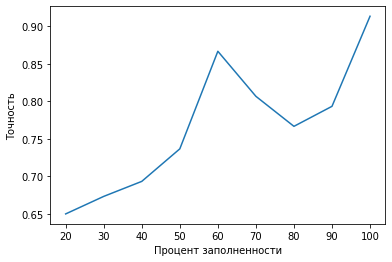

In [74]:
accuracy_grapf(10,svm.SVC(kernel = 'linear'),name_dir,y)

In [71]:
# И для второго датасета тоже построю
def accuracy_grapf_2(step,m_model,name_dir,y):
    acc=[]
    files = os.listdir(path=name_dir)
    K=len(files)
    for i in range(20,100+step,step):
        df=pd.read_csv('D2/Dataset_'+str(i)+'.csv') 

        train_X,test_X,train_y,test_y=test_and_train(K,df,y)
        
        model = m_model
        model.fit(train_X, train_y)

        y_pred = model.predict(test_X)
        acc.append(accuracy_score(test_y, y_pred))
        
    plt.plot(range(20,100+step,step),acc)
    plt.xlabel("Процент заполненности")
    plt.ylabel("Точность")
    plt.savefig('grf2.png')
    return acc

[0.5533333333333333,
 0.6066666666666667,
 0.64,
 0.7266666666666667,
 0.6966666666666667,
 0.6966666666666667,
 0.7366666666666667,
 0.78,
 0.82]

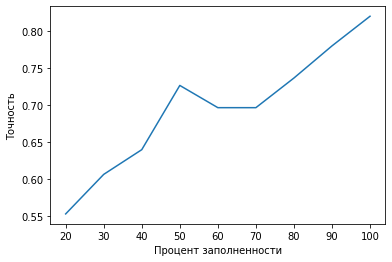

In [78]:
accuracy_grapf_2(10,best_model_2[0],name_dir,y)